In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from FlowCytometryTools import FCMeasurement

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def log_transform(original_sample, channels):
    """
    This function implements a log10 transformation on the data.
    It is preferable to the FCT transforms because they include
    some kind of normalization that I don't understand.
    By: Devin Strickland
    """
    # Copy the original sample
    new_sample = original_sample.copy()
    new_data = new_sample.data
    # log10 transformation of each specified channel
    for c in channels:
        new_data[c] = np.log10(new_data[c])
    new_data = new_data.replace([np.inf, -np.inf], np.nan)
#     new_data = new_data.dropna()  # Removes all NaN entries
    new_sample.data = new_data
    return new_sample

In [4]:
with open('../secrets.json') as jfile:
    secrets_json = json.load(jfile)
    FCS_PATH = secrets_json['FCS_PATH']

In [5]:
data_dir = '../data/test'
heat_dirs = ['202105', '202106']

In [6]:
cfu_data_list = list()
fcs_metadata_list = list()
for hdir in heat_dirs:
    for exp_dir in os.listdir(f'{data_dir}/{hdir}'):
        if 'heat' in exp_dir and exp_dir != 'heat_20210518':
            cfu_fcs_files = os.listdir(f'{data_dir}/{hdir}/{exp_dir}')
            cfu_fcs_files.sort()
            cfu_data_list.append(pd.read_csv(f'{data_dir}/{hdir}/{exp_dir}/{cfu_fcs_files[0]}'))
            fcs_metadata_list.append(pd.read_csv(f'{data_dir}/{hdir}/{exp_dir}/{cfu_fcs_files[1]}'))
cfu_data = pd.concat(cfu_data_list)
cfu_data.sort_values(by='treatment_concentration', inplace=True)
fcs_metadata = pd.concat(fcs_metadata_list)
fcs_metadata.sort_values(by='treatment_concentration', inplace=True)

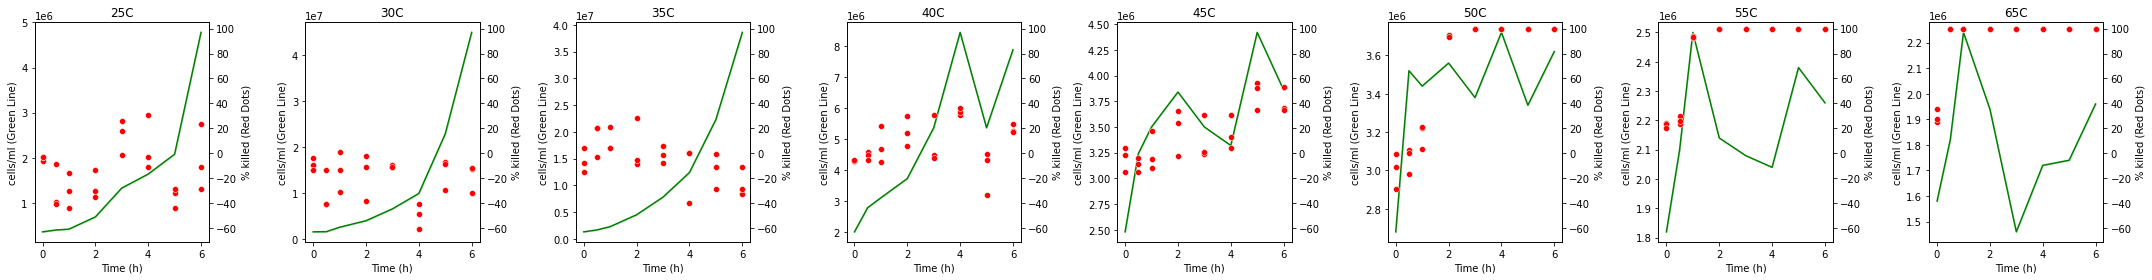

In [9]:
plot_cols = len(set(cfu_data['treatment_concentration']))
fig, axs = plt.subplots(figsize=(30,4), nrows=1, ncols=plot_cols, facecolor='white')

for plot_ax, treatment in zip(axs, sorted(set(cfu_data['treatment_concentration']))):
    cfu_df = cfu_data[cfu_data['treatment_concentration'] == treatment]
    sns.lineplot(data=cfu_df, x='treatment_time', y='culture_cells/ml', color='g', ax=plot_ax)
    ax2 = plot_ax.twinx()
    sns.scatterplot(data=cfu_df, x='treatment_time', y='percent_killed', ax=ax2, color='r')
    plot_ax.set_xlabel('Time (h)')
    plot_ax.set_ylabel('cells/ml (Green Line)')
    ax2.set_ylabel('% killed (Red Dots)')
    ax2.set_ylim(ymin=int(cfu_data['percent_killed'].min()) - 10, ymax=105)
#     plot_ax.set_ylim(ymin=0.0, ymax=4e7)
    plt.title(f'{int(treatment)}C')
plt.tight_layout()
plt.savefig('plots/heat_CFU_data.png', dpi=300, facecolor=fig.get_facecolor())

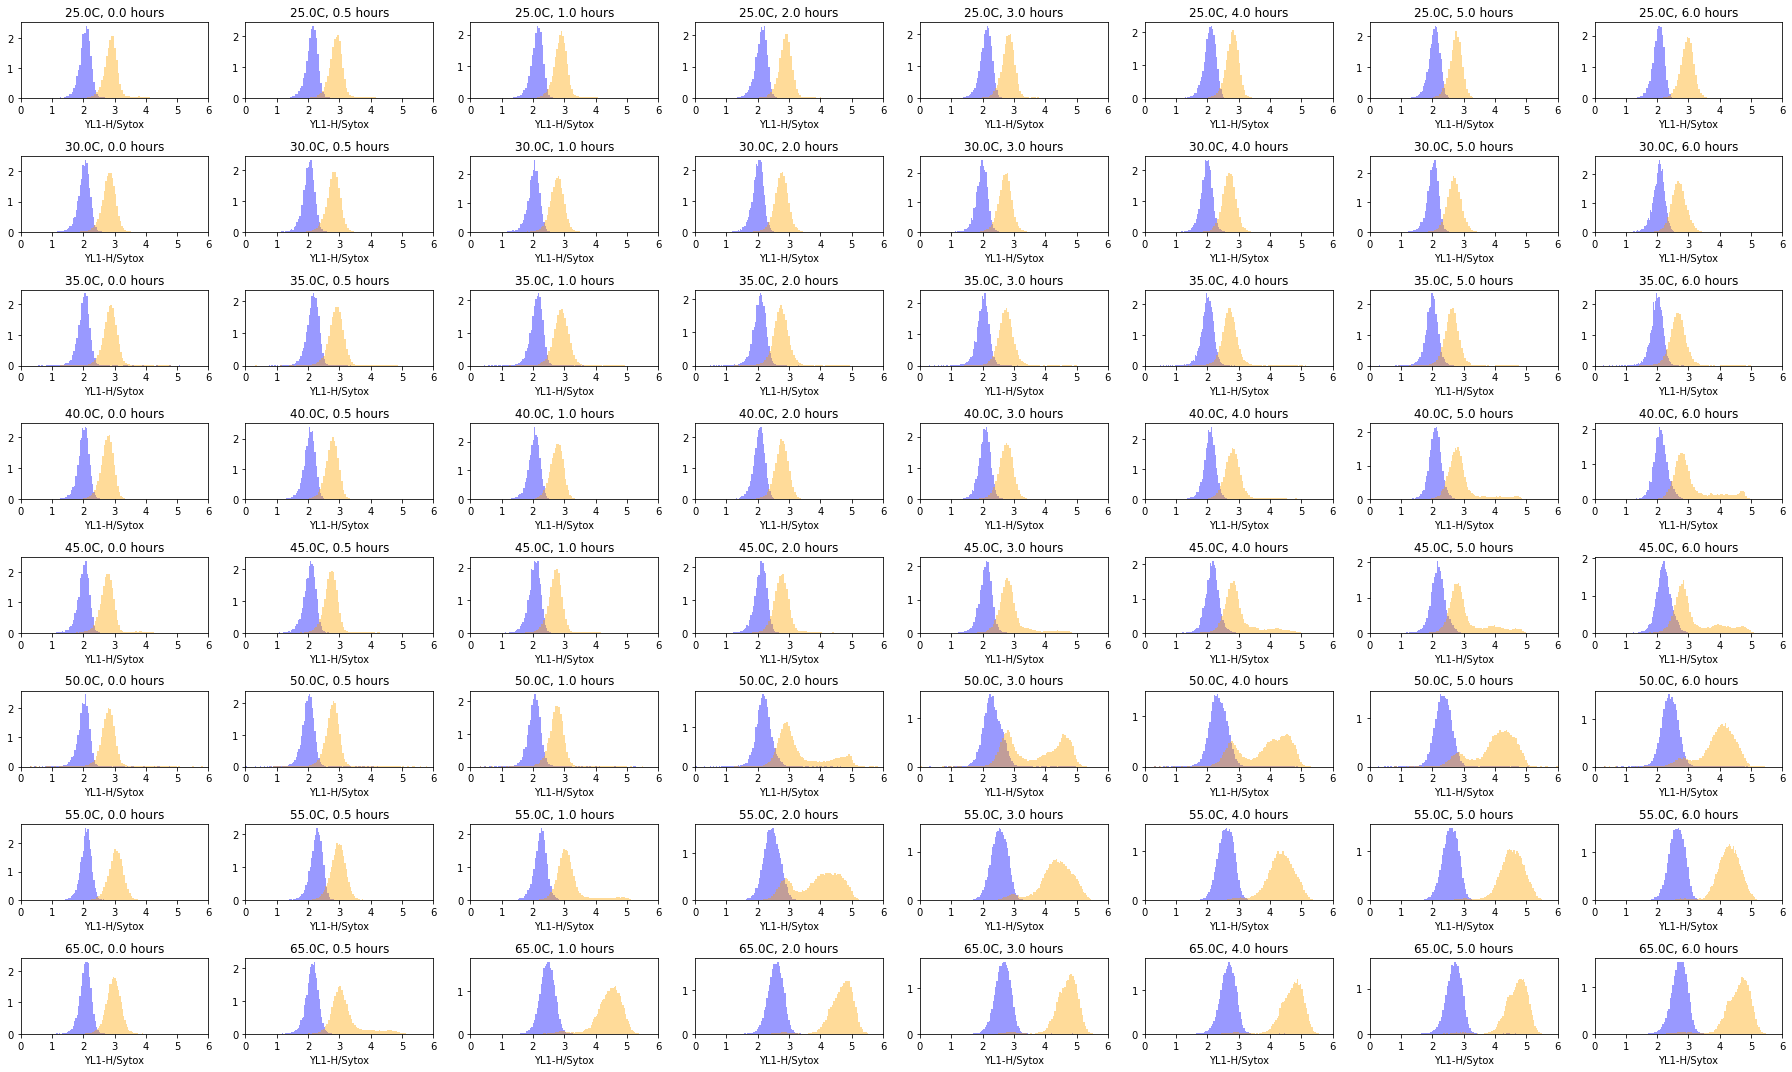

In [8]:
fig = plt.figure(figsize=(25,15), facecolor='white')
plot_rows = len(set(cfu_data['treatment_concentration']))
plot_cols = len(set(cfu_data['treatment_time']))
channel = 'YL1-H'

for row_idx, treatment in enumerate(sorted(set(cfu_data['treatment_concentration']))):
    for col_idx, timepoint in enumerate(sorted(set(cfu_data['treatment_time']))):
        plot_idx = ((row_idx+1) * plot_cols) + (col_idx+1) - plot_cols
        plt.subplot(plot_rows, plot_cols, plot_idx)
        
        fcs_metadata_df = fcs_metadata[(fcs_metadata['treatment_concentration'] == treatment) & (fcs_metadata['treatment_time'] == timepoint)]
        fcs_files = fcs_metadata_df['fcs_filename'].tolist()
        fcs_files.sort()
        exp_dir = fcs_metadata_df['experiment_id'].tolist()[0]
        fcs_no_stain = FCMeasurement(ID=fcs_files[0], datafile=f'{FCS_PATH}/{exp_dir}/{fcs_files[0]}')
        fcs_no_stain_log = log_transform(fcs_no_stain, [channel])
        fcs_stain = FCMeasurement(ID=fcs_files[1], datafile=f'{FCS_PATH}/{exp_dir}/{fcs_files[1]}')
        fcs_stain_log = log_transform(fcs_stain, [channel])

        sns.distplot(fcs_no_stain_log.data[channel].values, bins=100, color='blue', kde=False, norm_hist=True)
        sns.distplot(fcs_stain_log.data[channel].values, bins=100, color='orange', kde=False, norm_hist=True)

        plt.title(f'{treatment}C, {timepoint} hours')
        plt.xlim(0,6)
        plt.xlabel(f'{channel}/Sytox')

plt.tight_layout()
plt.savefig('plots/heat_fcs_data.png', dpi=300, facecolor=fig.get_facecolor())